In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import numpy as np
import shapely.geometry as shpg
import os
import sys
import json
import logging

In [2]:
sys.path.append(os.getcwd() + '/../..')
from utils import mkdir, open_zip_shapefile, open_tar_shapefile, haversine

In [3]:
log = logging.getLogger('papermill')
logging.basicConfig(level='INFO', format="%(message)s")

## Files and storage paths

In [4]:
# Region of interest
reg = 1

# go down from rgi7_scripts/workflow
data_dir = '../../../../rgi7_data/'

# Input dirctory
input_dir_tar = os.path.join(data_dir, 'l4_rgi7b0_tar')
input_dir = os.path.join(data_dir, 'l4_rgi7b0')

### Load the input data

In [5]:
reg_file = os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions')
reg_file = gpd.read_file(reg_file)
fname = reg_file.loc[reg_file['o1region'] == f'{reg:02d}'].iloc[0]['long_code']

In [6]:
# Read beta files
shp = open_tar_shapefile(input_dir_tar + f'/RGI2000-v7.0-G-{fname}.tar.gz')
odf_subm = pd.read_csv(input_dir + f'/RGI2000-v7.0-G-{fname}/RGI2000-v7.0-G-{fname}_subm_info.csv', index_col=0)

VSIFSeekL(xxx, SEEK_END) may be really slow on GZip streams.


## Printouts for docs 

In [7]:
for i, line in odf_subm.iterrows():
    print(f"Submission {i}")
    print(f": **Submitter**: {line['submitters']} ({line['chief_affl']})."
          f"<br/>**Number of outlines**: {line['n_outlines']}. **Area**: {line['area_km2']:.1f}km². **Release date**: {line['release_dt'][:10]}."
          f"<br/>**Analysts**: {line['analysts']}.")
    print(f"")

Submission 624
: **Submitter**: Cogley, Graham (University of Colorado).<br/>**Number of outlines**: 25305. **Area**: 82291.9km². **Release date**: 2015-07-16.<br/>**Analysts**: Beedle, Matthew; Berthier, Etienne; Bolch, Tobias; Burgess, Evan; Cogley, Graham; Forster, Richard; Giffen, Bruce A.; Hall, Dorothy K.; Kienholz, Christian; LeBris, Raymond; Manley, William.

Submission 756
: **Submitter**: Bolch, Tobias (University of Colorado).<br/>**Number of outlines**: 3. **Area**: 7.1km². **Release date**: 2021-10-10.<br/>**Analysts**: Beedle, Matthew; Berthier, Etienne; Bolch, Tobias; Burgess, Evan; Cogley, Graham; Forster, Richard; Giffen, Bruce A.; Hall, Dorothy K.; Kienholz, Christian; LeBris, Raymond; Manley, William.

Submission 766
: **Submitter**: McNabb, Robert (Ulster University).<br/>**Number of outlines**: 42. **Area**: 10.7km². **Release date**: 2020-07-22.<br/>**Analysts**: McNabb, Robert.

Submission 809
: **Submitter**: Yang, Ruitang (University of Oslo).<br/>**Number of o

## Maps 

In [8]:
import salem
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from matplotlib.image import imread
import seaborn as sns

In [86]:
rdf = salem.read_shapefile(os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions', '00_rgi70_O1Regions.shp'))
srdf = salem.read_shapefile(os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O2Regions', '00_rgi70_O2Regions.shp'))

rdf = rdf.loc[rdf['o1region'] == f'{reg:02d}']
srdf = srdf.loc[srdf['o1region'] == f'{reg:02d}']

In [106]:
extent = [rdf.min_x.iloc[0], rdf.max_x.iloc[0], rdf.min_y.iloc[0], rdf.max_y.iloc[0]]
extent

[-180.0, -126.791684008, 50.0, 72.0]

In [115]:
extent = [-180.0, -132, 46.0, 72.0]

In [116]:
map_crs = ccrs.LambertConformal(
    central_longitude=(extent[0] + extent[1]) / 2,
    central_latitude=(extent[2] + extent[3]) / 2,
    standard_parallels=(50, 65),
)

In [117]:
shp_repr = shp.to_crs(map_crs)

N=25305, A=82291.9 km²
N=3, A=7.1 km²
N=42, A=10.7 km²
N=1737, A=4120.4 km²
N=424, A=277.6 km²


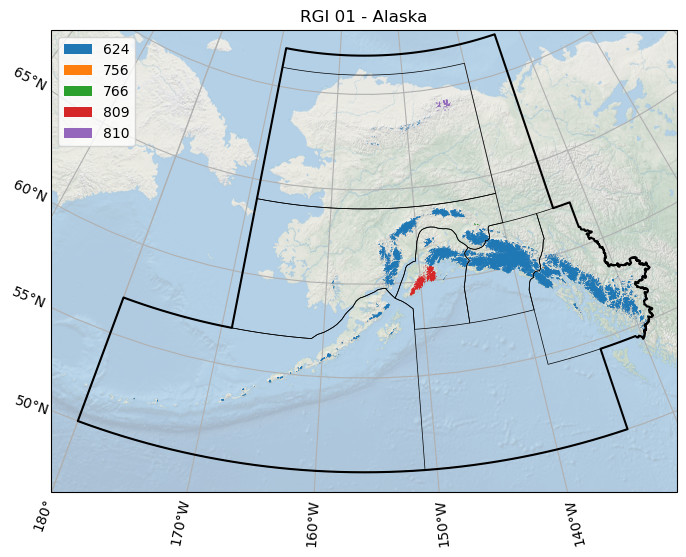

In [124]:
linewidth = 0.2
title = 'RGI 01 - Alaska' 
is_rgi6 = False

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=map_crs)
ax.set_extent(extent, crs=ccrs.Geodetic())

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, dms=True, 
                  xlocs=np.arange(37) * 10 - 180);
gl.top_labels = False
gl.right_labels = False

# fname = '/home/users/fmaussion/www_fmaussion/misc/rgi7_data/l0_support_data/images/natural-earth-1_large4096px.png'
fname = '/home/users/fmaussion/www_fmaussion/misc/rgi7_data/l0_support_data/images/natural-earth-1_large8192px_white.png'
ax.imshow(imread(fname), origin='upper', transform=ccrs.PlateCarree(), 
          extent=[-180, 180, -90, 90])

rdf.to_crs(map_crs).plot(ax=ax, edgecolor='k', facecolor='none', zorder=99, linewidth=1.5)
srdf.to_crs(map_crs).plot(ax=ax, edgecolor='k', facecolor='none', zorder=98, linewidth=0.5)

handles = []
if is_rgi6:
    for itis in [True, False]:
        ec = '#001fff' if itis else '#ff0000'
        fc = '#465dff' if itis else '#ff4646'
        label = 'Same as RGI6' if itis else 'New in RGI7'
        s_loc = shp_repr.loc[shp_repr['is_rgi6'] == itis]
        if len(s_loc) > 0:
            s_loc.plot(ax=ax, facecolor=fc, edgecolor=ec, linewidth=linewidth, zorder=97)
            area = s_loc['area_km2'].sum()
        else:
            area = 0
        print(f'N={len(s_loc)}, A={area:.1f} km²')
        handles.append(mpatches.Patch(facecolor=ec, label=f'{label}'))
else:
    for i, subid in enumerate(sorted(shp.subm_id.unique().astype(int))):
        fc = f'C{i}'
        ec = fc
        s_loc = shp_repr.loc[shp.subm_id == subid]
        s_loc.plot(ax=ax, facecolor=fc, edgecolor=ec, linewidth=linewidth, zorder=97)
        area = s_loc['area_km2'].sum()
        handles.append(mpatches.Patch(facecolor=fc, label=f'{subid}'))
        print(f'N={len(s_loc)}, A={area:.1f} km²')

# Alternative solution for "Polygon handles not passing to legend"
ax.legend(handles=handles, loc='upper left');
ax.set_title(title);

plot_dir = data_dir + f'/l4_rgi7b0_plots/RGI{reg:02d}'
mkdir(plot_dir)
plotname = 'isrgi6_map' if is_rgi6 else 'inventory_map'
plt.savefig(plot_dir + f'/{plotname}.jpeg', bbox_inches='tight', dpi=300)

### Histogram 

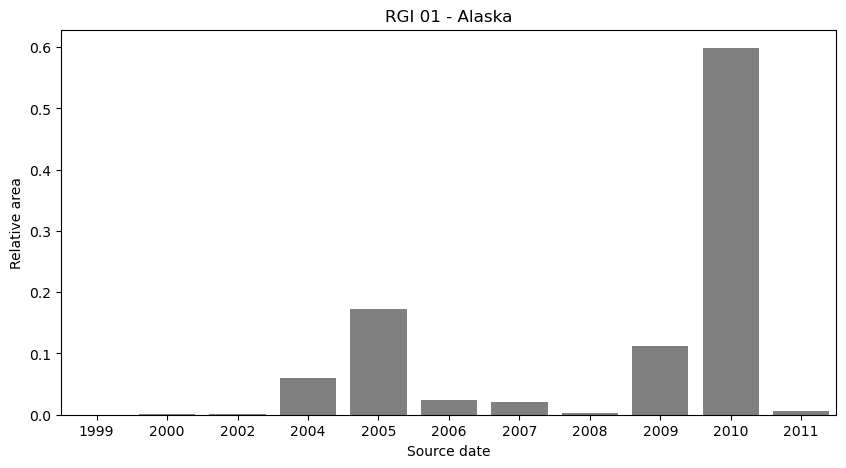

In [105]:
figsize=(10, 5)

f, ax = plt.subplots(figsize=figsize)

date = shp['src_date'].str[:4].astype(int).to_frame('src_date')
date['area'] = shp['area_km2']
date = date.groupby('src_date')['area'].sum().to_frame()
# if reset_index:
#     date = date.reindex(np.arange(date.index.min(), date.index.max()+1, dtype=int), fill_value=0)
date['area'] = date['area'] / date['area'].sum()
date = date.reset_index()

sns.barplot(ax=ax, x='src_date', y='area', data=date, color='grey');
ax.set_ylabel('Relative area'); ax.set_xlabel('Source date'); 
ax.set_title(title);

plot_dir = data_dir + f'/l4_rgi7b0_plots/RGI{reg:02d}'
mkdir(plot_dir)
plotname = 'date_hist'
plt.savefig(plot_dir + f'/{plotname}.png', bbox_inches='tight', dpi=300)